In [1]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf
using Compat

## Read data
Download if necessary

In [2]:
if !isfile("northsea_obs_01.nc")
    download("https://dox.ulg.ac.be/index.php/s/jX2FnNQUjRnKuri/download", "northsea_obs_01.nc")
else
    @info "File already downloaded"
end
if !isfile("northsea_obs_02.nc")
    download("https://dox.ulg.ac.be/index.php/s/dOhPUX5e7eEw5L0/download", "northsea_obs_02.nc")
else
    @info "File already downloaded"
end

┌ Info: File already downloaded
└ @ Main In[2]:4
┌ Info: File already downloaded
└ @ Main In[2]:9


In [3]:
varname = "sea_water_salinity"
@time obsval1, obslon1, obslat1, obsdepth1, obstime1, obsid1 = 
DIVAnd.loadobs(Float64, "northsea_obs_01.nc", varname);

@time obsval2, obslon2, obslat2, obsdepth2, obstime2, obsid2 = 
DIVAnd.loadobs(Float64, "northsea_obs_02.nc", varname);

  2.975623 seconds (6.81 M allocations: 360.216 MiB, 7.78% gc time)
  0.015247 seconds (61.57 k allocations: 10.362 MiB)


In [4]:
ndata1 = length(obslon1);
ndata2 = length(obslon2);
@info("Number of data in dataset 1: $(ndata1)")
@info("Number of data in dataset 2: $(ndata2)")

┌ Info: Number of data in dataset 1: 18159
└ @ Main In[4]:3
┌ Info: Number of data in dataset 2: 30564
└ @ Main In[4]:4


### Data plot

In [5]:
function plot_data_post(obslon1::Array, obslat1::Array, obslon2::Array, obslat2::Array)
    PyPlot.plot(obslon1, obslat1, "ko", markersize=0.03, alpha=.7)
    PyPlot.plot(obslon2, obslat2, "ro", markersize=0.03, alpha=.7)
end

plot_data_post (generic function with 1 method)

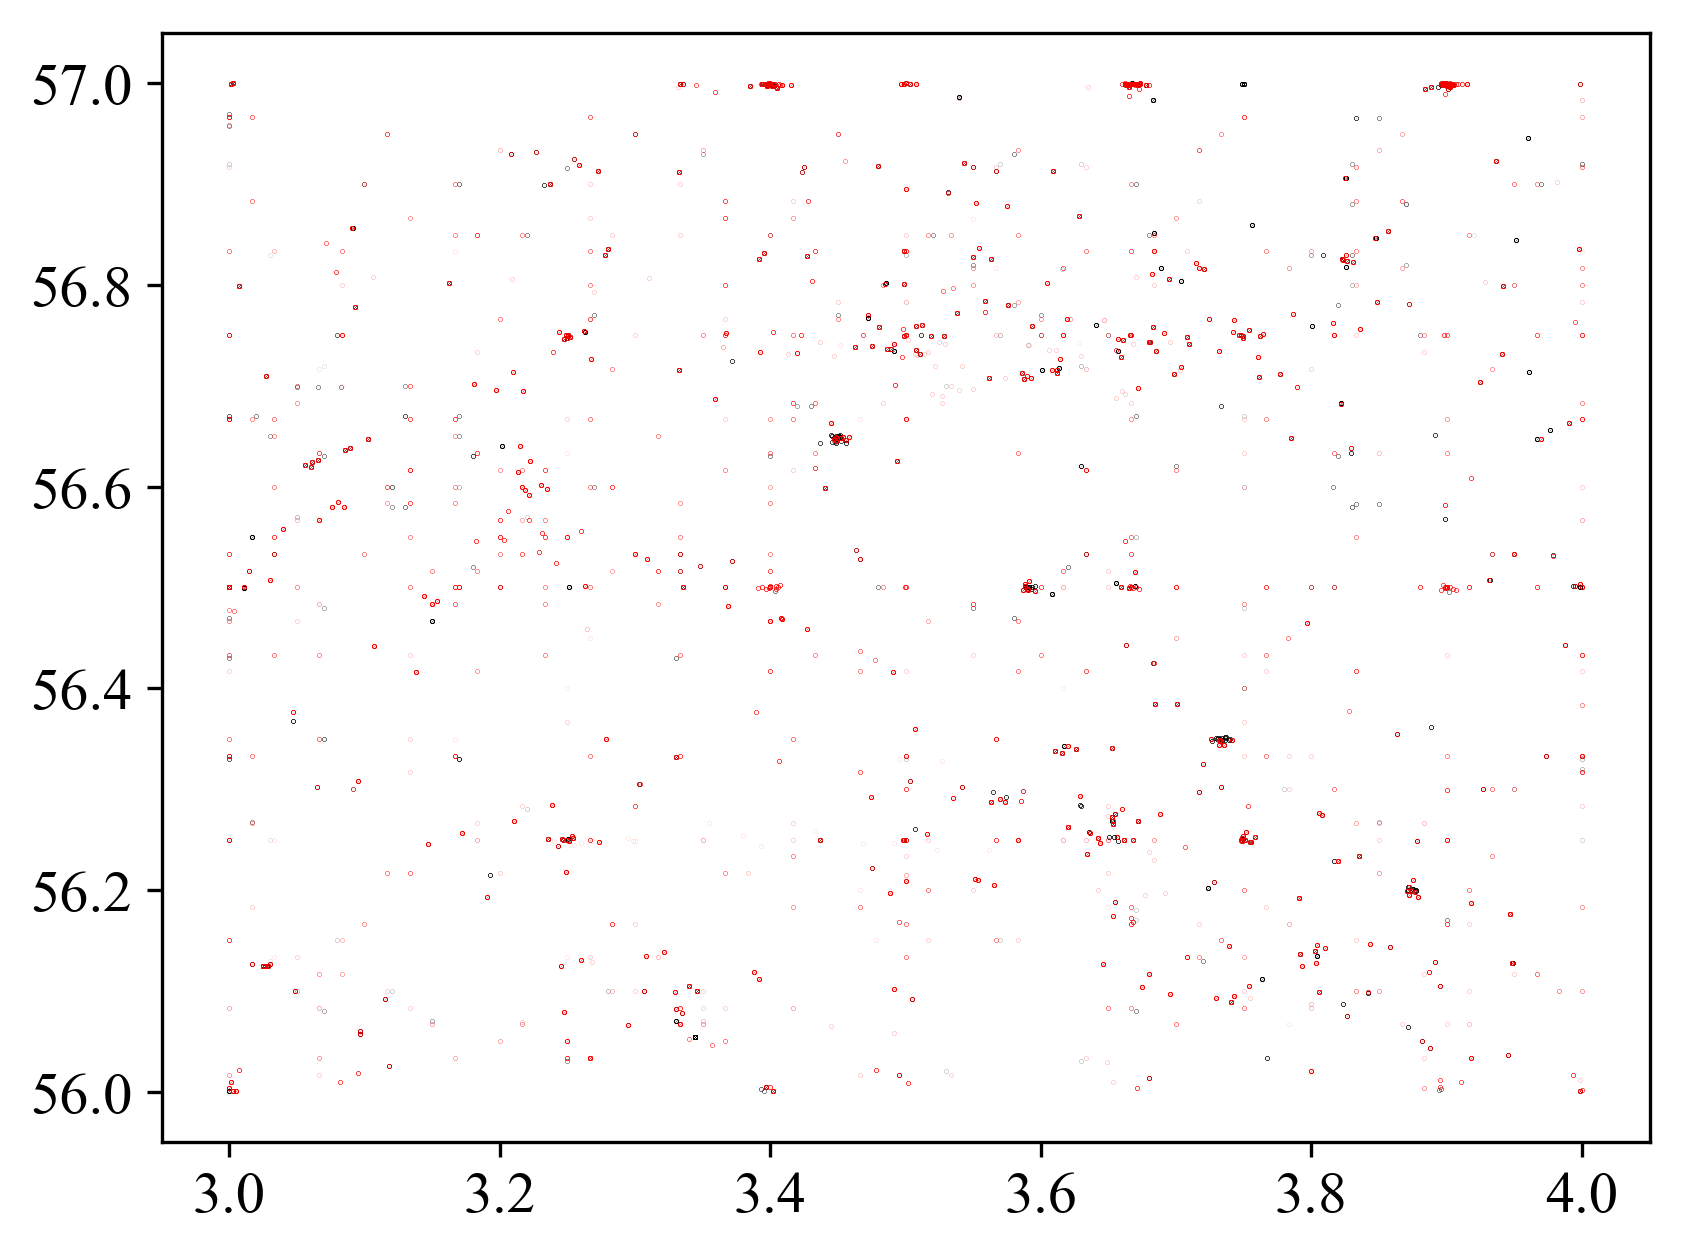

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc7931eeb38>

In [6]:
plot_data_post(obslon1, obslat1, obslon2, obslat2)

## Duplicate detection
We check for different values of the parameters how many duplicates are found.

In [7]:
Δlon = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0];
Δdepth = [0.005, 0.01, 0.05, 0.1, 0.5, 1., 5.0];

In [8]:
duplicate_percent = Array{Float64}(undef, length(Δlon), length(Δdepth))

for (i, dx) in enumerate(Δlon)
    for (j, dz) in enumerate(Δdepth)
        @time dupl = DIVAnd.Quadtrees.checkduplicates(
            (obslon1,obslat1,obsdepth1,obstime1), obsval1,
            (obslon2,obslat2,obsdepth2,obstime2), obsval2,
            (dx, dx, dz,1/(24.)),0.01);

            index = findall(.!isempty.(dupl));
            ndupl = length(index);
            pcdupl = (ndupl / ndata1) * 100.;
            @debug("Number of possible duplicates: $ndupl")
            @debug("Percentage of duplicates: $pcdupl%")

            duplicate_percent[i, j] = pcdupl;
    end
end

  2.060667 seconds (3.48 M allocations: 194.611 MiB, 5.86% gc time)
  0.655229 seconds (57.61 k allocations: 31.309 MiB, 0.40% gc time)
  0.672395 seconds (97.17 k allocations: 56.664 MiB, 1.26% gc time)
  0.635548 seconds (102.28 k allocations: 59.938 MiB, 1.00% gc time)
  0.643701 seconds (121.56 k allocations: 72.286 MiB, 0.96% gc time)
  0.653238 seconds (126.37 k allocations: 75.479 MiB, 1.78% gc time)
  0.708307 seconds (137.41 k allocations: 84.441 MiB, 1.31% gc time)
  0.657525 seconds (56.66 k allocations: 30.701 MiB, 1.02% gc time)
  0.645402 seconds (61.43 k allocations: 33.760 MiB, 0.36% gc time)
  0.650227 seconds (102.78 k allocations: 60.259 MiB, 0.96% gc time)
  0.666699 seconds (108.04 k allocations: 63.628 MiB, 1.03% gc time)
  0.704479 seconds (128.96 k allocations: 77.029 MiB, 1.39% gc time)
  0.755079 seconds (134.80 k allocations: 80.531 MiB, 10.86% gc time)
  0.726660 seconds (146.33 k allocations: 90.253 MiB, 1.76% gc time)
  0.662379 seconds (57.09 k allocation

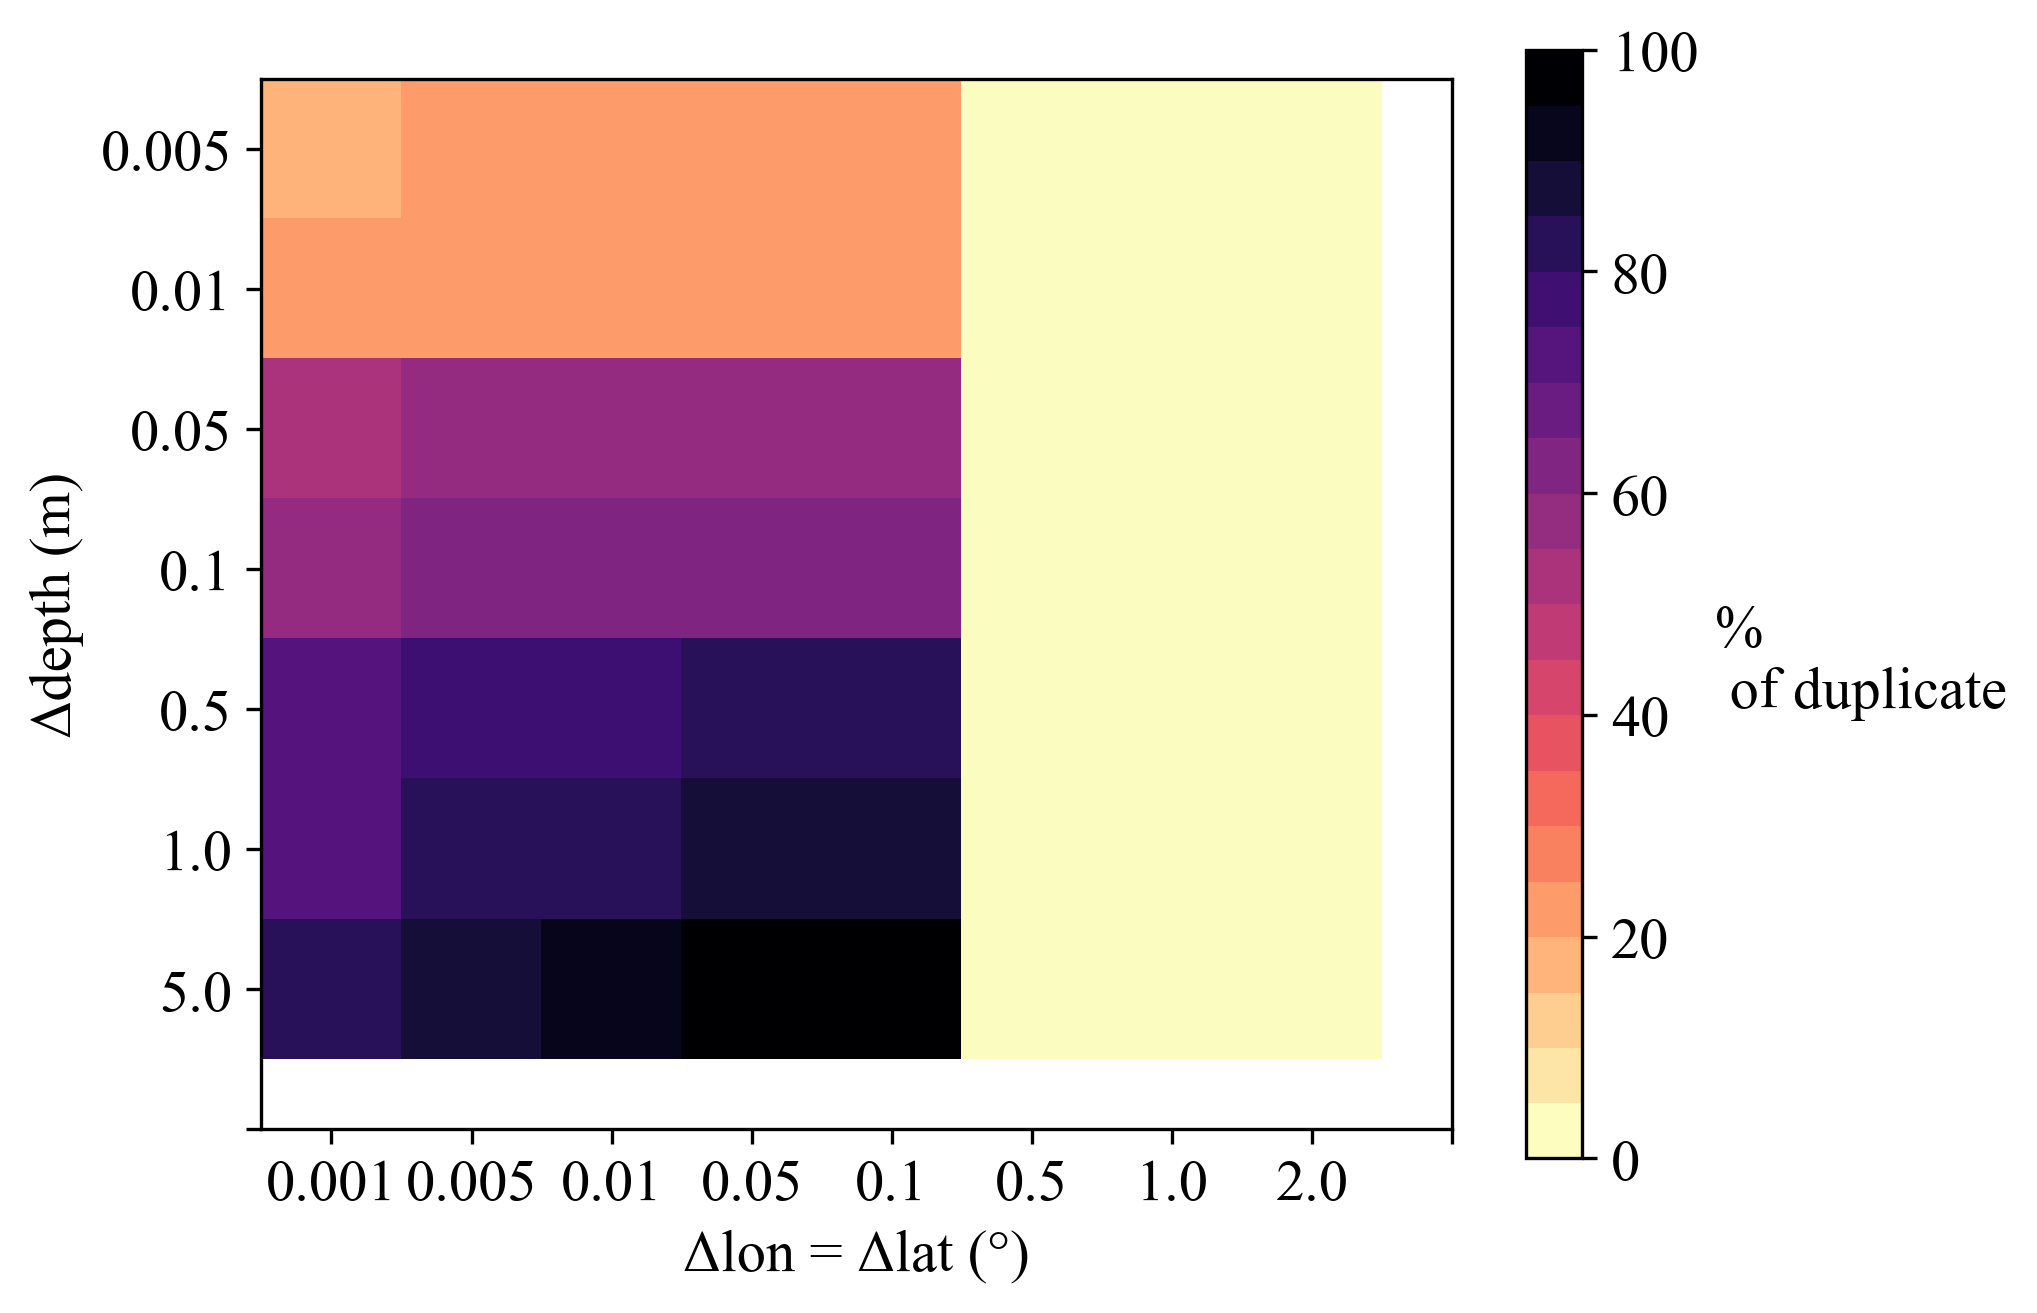

In [9]:
cmap = PyPlot.cm.get_cmap("magma_r", 20)
ax = subplot(111)
pc = imshow(permutedims(duplicate_percent, [2,1]), cmap=cmap, vmin=0, vmax=100)
ax.set_xticks(0:length(Δlon))
ax.set_yticks(0:length(Δdepth))
ax.set_xticklabels(Δlon)
ax.set_yticklabels(Δdepth)
xlabel("Δlon = Δlat (°)")
ylabel("Δdepth (m)")
cb = colorbar(pc)
cb.set_label("%\n of duplicate", rotation=0, ha="left")

### Comments
* For large values (>= 0.5°) of the horizontal length, the percentage of duplicates is only 0.01%, while we would expect more duplicates when we increase the *searching radius*.
* For large values of the vertical length (>= 0.05), the horizontal length has not a large influence, i.e., we don't detect more possible duplicates.
* When doing from Δz=0.05 m to Δz=0.01 m, the percentage of duplicates changes abruptly, going from about 25% to more than 55%. 

Now let's check what happens with large horizontal length

In [10]:
ENV["JULIA_DEBUG"] = "all"
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (obslon1,obslat1,obsdepth1,obstime1), obsval1,
            (obslon2,obslat2,obsdepth2,obstime2), obsval2,
            (1.0, 0.5, 0.01, 1/(24.)), 0.01);

            index = findall(.!isempty.(dupl));
            ndupl = length(index);
            pcdupl = ndupl / ndata1 * 100;
@show pcdupl;
index

  0.026108 seconds (31.21 k allocations: 14.352 MiB)
pcdupl = 0.0055069111735227706


1-element Array{Int64,1}:
 24374

Only 0.01% of duplicates found...           
Let's plot in an even smaller area.

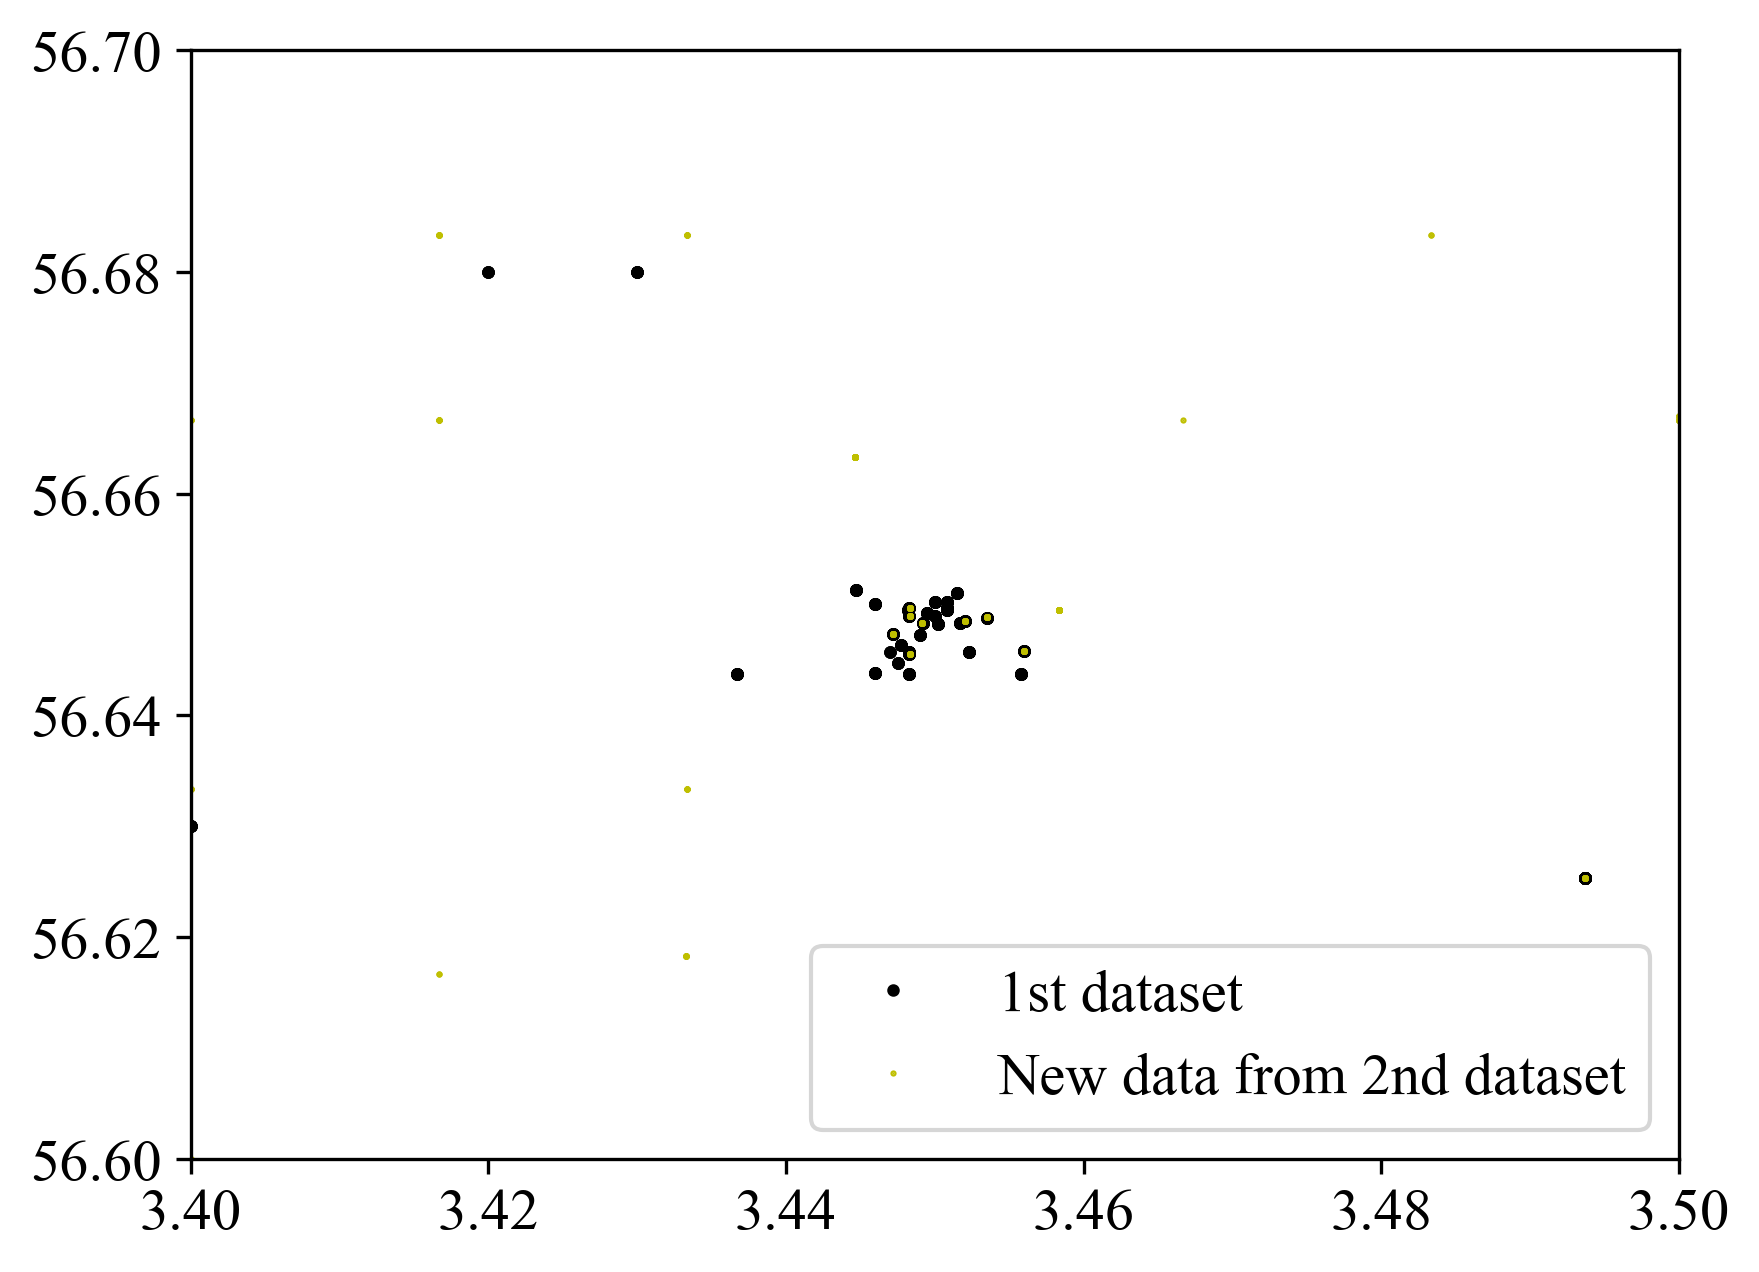

(56.6, 56.7)

In [11]:
newpoints = isempty.(dupl);
PyPlot.plot(obslon1, obslat1, "ko", markersize=2, label="1st dataset")
PyPlot.plot(obslon2[newpoints], obslat2[newpoints], "y.", 
    markersize=1, label="New data from 2nd dataset")
PyPlot.legend()
xlim(3.4, 3.5)
ylim(56.6, 56.7)

It seems some of the *new* observations from the 2nd dataset are at the same position, maybe because the depth or the depth, time or value differ. Too many variables at the same time to understand what is going on.

## Artificial case
We create 2 synthetic 2D dataset using random positions and values.

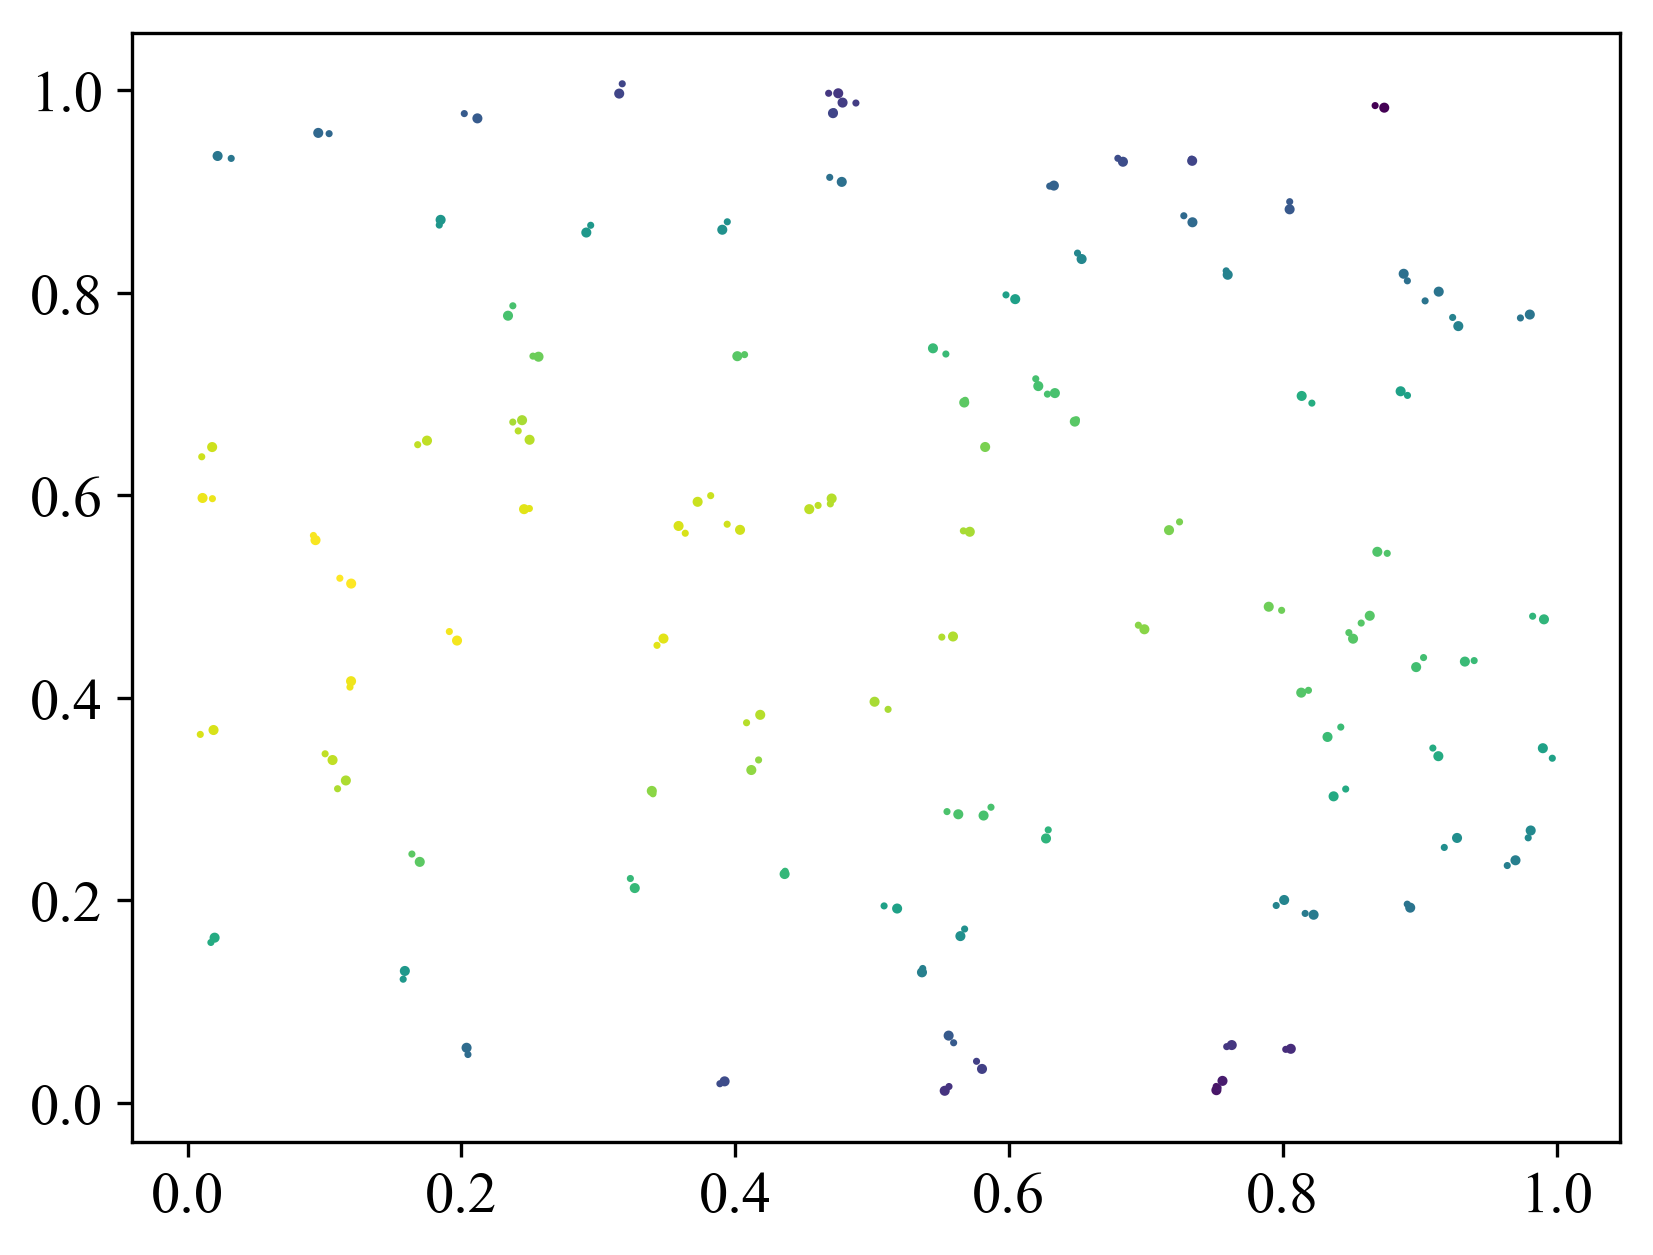

PyObject <matplotlib.collections.PathCollection object at 0x7fc792ffc358>

In [12]:
NN = 100;
err = 0.02
Random.seed!(642);
x1 = rand(NN);
Random.seed!(891);
y1 = rand(NN);
z1 = cos.(x1) + sin.(π * y1);
x2 = x1 .+ err * (rand(NN) .- 0.5)
y2 = y1 .+ err * (rand(NN) .- 0.5)
PyPlot.scatter(x1, y1, c=z1, s=2)
PyPlot.scatter(x2, y2, c=z1, s=.5)

### Duplicate detection with a large L

In [13]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z1,
            (err * 2, err * 2), 0.01);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100;
@show pcdupl;

  0.370151 seconds (819.15 k allocations: 39.705 MiB, 3.39% gc time)
pcdupl = 100.0


### Duplicate detection with a small L

In [14]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z1,
            (err * 0.01, err * 0.01), 0.01);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100;
@show pcdupl;

  0.000253 seconds (189 allocations: 29.969 KiB)
pcdupl = 3.0


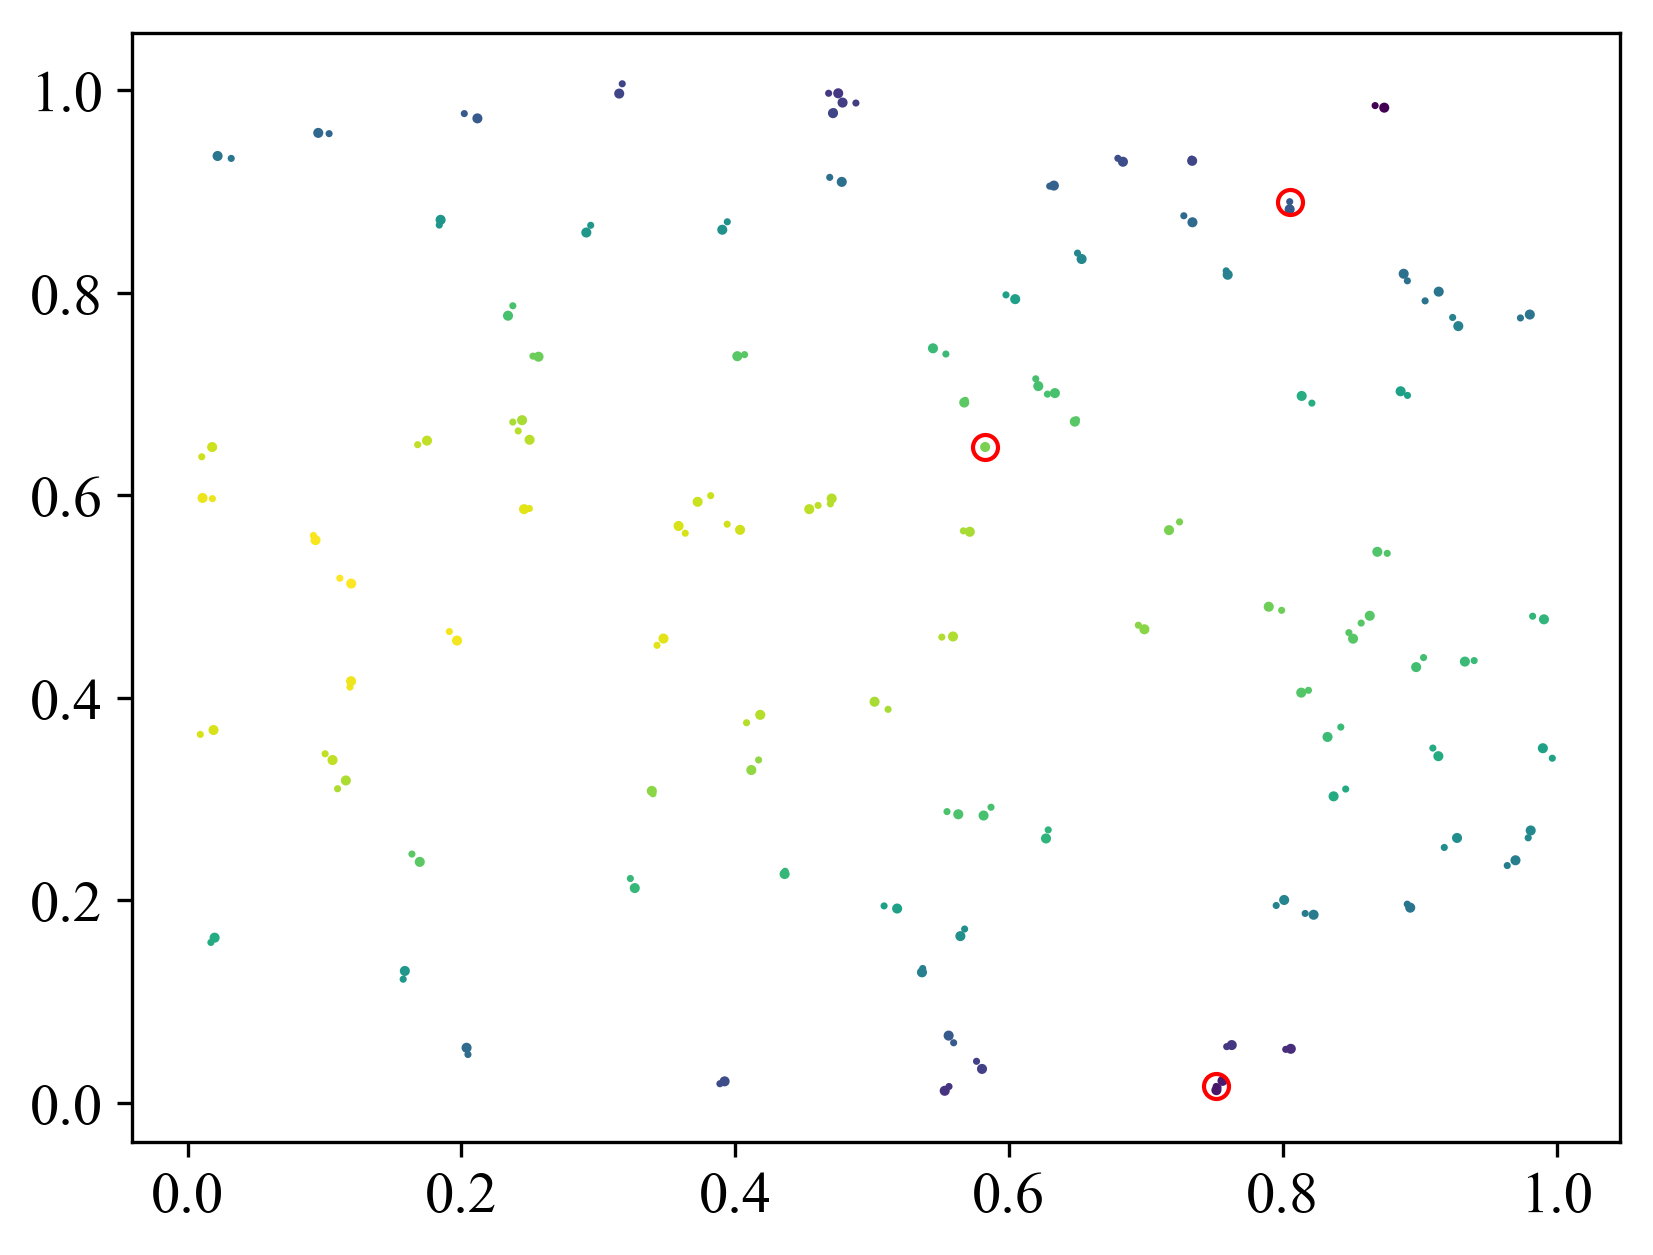

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc792fdd7f0>

In [15]:
PyPlot.scatter(x1, y1, c=z1, s=2)
PyPlot.scatter(x2, y2, c=z1, s=.5)
PyPlot.plot(x2[index], y2[index], "ro", markersize=6, markerfacecolor="None")

### Very big values of L
We get (as expected) 100% of duplicates.

In [16]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z1,
            (err * 10000., err * 10000.), 0.01);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100
@show pcdupl;

  0.000261 seconds (868 allocations: 555.281 KiB)
pcdupl = 100.0
